In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [2]:
#hide
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v4.0.0


# Multilingual Named Entity Recognition

## The Dataset

In [3]:
#id jeff-dean-ner
#caption An example of a sequence annotated with named entities
#hide_input
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [4]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [5]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [6]:
# hide_output
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [7]:
# hide_output
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

In [8]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [9]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [10]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: List(Value('string'))
ner_tags: List(ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG',
'B-LOC', 'I-LOC']))
langs: List(Value('string'))


In [11]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'])


In [12]:
# hide_output
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

In [13]:
# hide_output
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [14]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## Multilingual Transformers

## A Closer Look at Tokenization

In [15]:
# hide_output
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [16]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [17]:
#hide_input
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


### The Tokenizer Pipeline

<img alt="Tokenizer pipeline" caption="The steps in the tokenization pipeline" src="images/chapter04_tokenizer-pipeline.png" id="toknizer-pipeline"/>

### The SentencePiece Tokenizer

In [18]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

## Transformers for Named Entity Recognition

<img alt="Architecture of a transformer encoder for classification." caption="Fine-tuning an encoder-based transformer for sequence classification" src="images/chapter04_clf-architecture.png" id="clf-arch"/>

<img alt="Architecture of a transformer encoder for named entity recognition. The wide linear layer shows that the same linear layer is applied to all hidden states." caption="Fine-tuning an encoder-based transformer for named entity recognition" src="images/chapter04_ner-architecture.png" id="ner-arch"/>

## The Anatomy of the Transformers Model Class

### Bodies and Heads

<img alt="bert-body-head" caption="The `BertModel` class only contains the body of the model, while the `BertFor&lt;Task&gt;` classes combine the body with a dedicated head for a given task" src="images/chapter04_bert-body-head.png" id="bert-body-head"/>

### Creating a Custom Model for Token Classification

In [19]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

### Loading a Custom Model

In [20]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [21]:
# hide_output
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [22]:
# hide_output
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

In [23]:
# hide_output
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [24]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [25]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-PER,B-LOC,I-ORG,B-LOC,B-LOC,I-ORG,I-ORG,I-ORG,I-ORG,I-PER


helper関数tag_textを用意。<br>
文章からxlmr_tokenizerを使って作成したトークンと、そのトークンを分類した結果を比較するDFを作成する。

In [26]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])
    

## Tokenizing Texts for NER

In [27]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [28]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [29]:
#hide_output
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [30]:
# hide_output
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [31]:
#hide_output
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx
    
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [32]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [33]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [34]:
# hide_output
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

## Performance Measures

In [35]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [36]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## Fine-Tuning XLM-RoBERTa

In [ ]:
# hide_output
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=True,
    hub_model_id="RyotaBannai/xlm-roberta-base-finetuned-panx-de"
    )

RepoUrl('https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de', endpoint='https://huggingface.co', repo_type='model', repo_id='RyotaBannai/xlm-roberta-base-finetuned-panx-de')

In [52]:
#hide_output
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from huggingface_hub import create_repo
create_repo("xlm-roberta-base-finetuned-panx-de", repo_type="model", exist_ok=True)

In [53]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [54]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [55]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [56]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [57]:
# hide_output
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

/home/dev/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de into local empty directory.


In [58]:
#hide_input
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/home/dev/.venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.167057,0.817123
2,No log,0.140331,0.840941
3,No log,0.137746,0.851004


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

Upload file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0:   0%|      …

Upload file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.65…

Upload file training_args.bin:   0%|          | 1.00/3.89k [00:00<?, ?B/s]

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   7e29055..1469f77  main -> main

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   1469f77..4a53aef  main -> main



'https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de/commit/1469f775eb4e19c4eab6b4bd29b1cd2493858064'

In [61]:
# hide_input
df = pd.DataFrame(trainer.state.log_history)[['epoch','train_loss','eval_loss','eval_f1']]
df = df.rename(columns={"epoch":"Epoch","train_loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,NaN,0.167057,0.817123
1,2,NaN,0.140331,0.840941
2,3,NaN,0.137746,0.851004
3,3,0.204569,0.137746,0.851004


In [62]:
pd.DataFrame(trainer.state.log_history)

,eval_loss,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.167057,0.817123,6.0920,1032.506,10.834,1.0,132,NaN,NaN,NaN,NaN,NaN
1,0.140331,0.840941,6.4683,972.442,10.204,2.0,264,NaN,NaN,NaN,NaN,NaN
2,0.137746,0.851004,6.3613,988.797,10.375,3.0,396,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,3.0,396,89.1977,423.105,4.44,1.119295e+15,0.204569


In [63]:
# hide_output
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,B-PER,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-PER


## Error Analysis

In [64]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [65]:
# hide_output
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [66]:
# hide_output
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.062983245, 0.0, 0.07244734, 0.05224982...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [67]:
# hide_output
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.06,B-ORG,▁Ham
0,15,1,I-ORG,0.07,I-ORG,▁(
0,16104,1,I-ORG,0.05,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.07,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.22,B-ORG,▁Luz
1,10,1,I-ORG,0.16,I-ORG,▁a


In [68]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁von,▁in,▁der,▁und,▁/,▁(,▁'',▁),▁A
count,6066,808,989,1388,1171,163,246,2898,246,125
mean,0.04,0.15,0.12,0.08,0.07,0.5,0.3,0.03,0.28,0.39
sum,219.02,122.94,122.79,117.28,85.07,82.25,73.21,72.55,68.7,49.11


In [69]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.66,0.6,0.45,0.36,0.28,0.18,0.03
sum,971.3,1612.94,1733.89,1135.72,815.52,756.82,1416.69


In [70]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

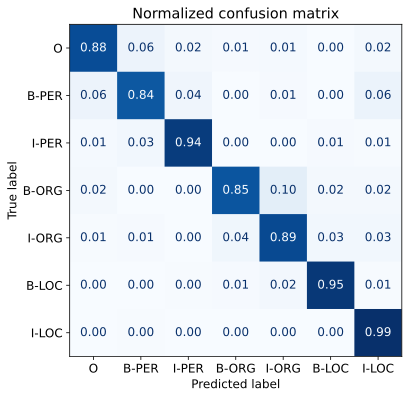

In [71]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [ ]:
# hide_output
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]): # 系列の一つ一つの要素ごとにチェック
            if i not in {0, len(row["attention_mask"])}: # 最初と最後以外なら:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.15,0.00,0.00,0.00,9.28,9.08,7.02,7.85,8.57,0.00,7.96,8.51,0.00,8.71,8.82,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.25,0.00,0.00,6.92,8.47,8.80,5.30,0.00,7.92,8.24,7.43,3.22,4.17,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,5.16,5.07,5.44,0.00,5.42,0.00,5.43,0.00,4.97,5.09,5.07,4.79,4.45,4.55,0.00


In [73]:
# hide_output
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.06,0.00,0.07,0.05,0.07,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.06,0.00,0.00,0.04,0.04,0.00,0.04,0.00


## Cross-Lingual Transfer

In [74]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [75]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


F1-score of [de] model on [de] dataset: 0.853


In [76]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,B-PER,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,B-LOC,I-LOC,I-PER


In [77]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [78]:
# hide_output
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


F1-score of [de] model on [fr] dataset: 0.693


In [79]:
# hide_input
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

F1-score of [de] model on [fr] dataset: 0.693


In [80]:
# hide_output
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset: 0.692


In [81]:
# hide_input
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.692


In [82]:
#hide_output
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] dataset: 0.596


In [83]:
#hide_input
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.596


### When Does Zero-Shot Transfer Make Sense?

In [84]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [85]:
# hide_output
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [86]:
# hide_output
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

/home/dev/.venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,1.906041,0.144335
2,No log,1.454146,0.033522
3,No log,1.427369,0.008245


,num_samples,f1_score
0,250,0.008379


In [87]:
#hide_input
# Hack needed to exclude the progress bars in the above cell
metrics_df

,num_samples,f1_score
0,250,0.008379


In [89]:
# hide_output
for num_samples in [500, 1000, 2000, 4000]:
    new_metrics = train_on_subset(panx_fr_encoded, num_samples)
    metrics_df = pd.concat([metrics_df, new_metrics], ignore_index=True)

/home/dev/.venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,1.467897,0.008145
2,No log,1.268495,0.108903
3,No log,1.174564,0.149440


Epoch,Training Loss,Validation Loss,F1
1,No log,1.182992,0.167084
2,No log,0.841540,0.455141
3,No log,0.704709,0.603175


Epoch,Training Loss,Validation Loss,F1
1,No log,0.805189,0.495452
2,No log,0.443504,0.694002
3,No log,0.392915,0.752176


Epoch,Training Loss,Validation Loss,F1
1,No log,0.409252,0.730065
2,No log,0.342048,0.773040
3,No log,0.312838,0.802262


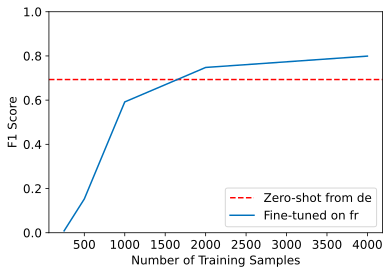

In [90]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

### Fine-Tuning on Multiple Languages at Once

In [91]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [92]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [93]:
# hide_output
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/home/dev/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de into local empty directory.


Download file pytorch_model.bin:   0%|          | 2.79k/1.03G [00:00<?, ?B/s]

Download file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.…

Download file training_args.bin: 100%|##########| 3.89k/3.89k [00:00<?, ?B/s]

Clean file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.658…

Clean file training_args.bin:  26%|##5       | 1.00k/3.89k [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 9.39k/16.3M [00:00<?, ?B/s]

Download file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0: 100%|####…

Clean file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0:  20%|##     …

Download file sentencepiece.bpe.model:   0%|          | 2.79k/4.83M [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

/home/dev/.venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.194540,0.807521
2,No log,0.161634,0.840831
3,No log,0.157823,0.849703


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.95k [00:00<?, ?B/s]

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   4a53aef..0ea0e9e  main -> main

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   0ea0e9e..47ef6d5  main -> main



'https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de/commit/0ea0e9e59ccae58fbde444bf967e4e440d7424d0'

In [94]:
#hide_output
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


F1-score of [de-fr] model on [de] dataset: 0.855
F1-score of [de-fr] model on [fr] dataset: 0.840
F1-score of [de-fr] model on [it] dataset: 0.795
F1-score of [de-fr] model on [en] dataset: 0.677


In [95]:
#hide_input
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

F1-score of [de-fr] model on [de] dataset: 0.855
F1-score of [de-fr] model on [fr] dataset: 0.840
F1-score of [de-fr] model on [it] dataset: 0.795
F1-score of [de-fr] model on [en] dataset: 0.677


In [96]:
# hide_output
corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

/home/dev/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.39k/1.03G [00:00<?, ?B/s]

Download file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0: 100%|####…

Download file sentencepiece.bpe.model:   0%|          | 16.0k/4.83M [00:00<?, ?B/s]

Download file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.…

Clean file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0:  20%|##     …

Clean file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.658…

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.95k/3.95k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##5       | 1.00k/3.95k [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 14.7k/16.3M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

/home/dev/.venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.394467,0.751237
2,No log,0.304322,0.798807
3,No log,0.292374,0.815680


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.95k [00:00<?, ?B/s]

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   47ef6d5..227aa1d  main -> main

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   227aa1d..e596a85  main -> main

/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/dev/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/1.03G [00:00<?, ?B/s]

Download file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.…

Download file sentencepiece.bpe.model:   0%|          | 8.00k/4.83M [00:00<?, ?B/s]

Clean file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.658…

Download file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0: 100%|####…

Clean file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0:  20%|##     …

Download file training_args.bin: 100%|##########| 3.95k/3.95k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##5       | 1.00k/3.95k [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 13.9k/16.3M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

/home/dev/.venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.788490,0.243040
2,No log,0.482241,0.662210
3,No log,0.380148,0.710266


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.95k [00:00<?, ?B/s]

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   e596a85..b398c49  main -> main

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   b398c49..c01d2e8  main -> main

/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/dev/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/1.03G [00:00<?, ?B/s]

Download file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.…

Download file sentencepiece.bpe.model:   0%|          | 8.00k/4.83M [00:00<?, ?B/s]

Clean file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.658…

Download file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0: 100%|####…

Clean file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0:  20%|##     …

Download file tokenizer.json:   0%|          | 8.00k/16.3M [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.95k/3.95k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##5       | 1.00k/3.95k [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

/home/dev/.venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,1.128583,0.156863
2,No log,0.810949,0.402813
3,No log,0.710796,0.481977


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.95k [00:00<?, ?B/s]

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   c01d2e8..bae143b  main -> main

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   bae143b..2ed8ad6  main -> main

/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [97]:
corpora_encoded = concatenate_splits(corpora)

In [98]:
# hide_output
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/home/dev/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/1.03G [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 8.00k/16.3M [00:00<?, ?B/s]

Download file sentencepiece.bpe.model:   0%|          | 8.00k/4.83M [00:00<?, ?B/s]

Download file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0: 100%|####…

Download file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.…

Clean file runs/Aug17_04-54-52_f84965a81361/1755406506.3674514/events.out.tfevents.1755406506.f84965a81361.658…

Clean file runs/Aug17_04-54-52_f84965a81361/events.out.tfevents.1755406506.f84965a81361.658188.0:  20%|##     …

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.95k/3.95k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##5       | 1.00k/3.95k [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

/home/dev/.venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.197789,0.807174
2,No log,0.173215,0.835505
3,No log,0.167604,0.847156


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.95k [00:00<?, ?B/s]

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   2ed8ad6..a092c84  main -> main

To https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de
   a092c84..f205814  main -> main



'https://huggingface.co/RyotaBannai/xlm-roberta-base-finetuned-panx-de/commit/a092c8495037074bc069f6f0bfff0053552bc345'

In [99]:
# hide_output
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [100]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8528,0.6931,0.6918,0.5956
each,0.8528,0.8131,0.6988,0.5136
all,0.8570,0.8543,0.8525,0.7598


## Interacting with Model Widgets

<img alt="A Hub widget" caption="Example of a widget on the Hugging Face Hub" src="images/chapter04_ner-widget.png" id="ner-widget"/>  

## Conclusion